In [1]:
import pickle
from datetime import datetime as dt
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import data_exploration_tools as EDA

Import the most recent data.

In [2]:
day = dt.today().day
month = dt.today().month
year = dt.today().year

dt_str = os.path.join('.', 'reddit_data_{}-{}-{}'.format(month, day, year) )

df = pd.read_pickle(dt_str)

Clean up the data by building a few new simple features, dropping useless columns (including those which have a cardinality of 1), and dropping all instances of Subreddits which aren't useful to the endeavor (e.g. '\r\blog' which only has two posts, both of which are gilded, and is a subreddit entirely devoted to Moderator posts about the Reddit platform itself).

In [3]:
new_feats = ['gilded', 'weekday', 'post_hour', 'scrape_time']
new_cols = EDA.handle_unique_columns(df)

for idx, feature in enumerate(new_feats):
    df[feature] = new_cols[idx]

df.drop(columns = EDA.get_all_useless_cols(df), inplace = True)
df = EDA.remove_useless_subreddits(df, ['blog']).reset_index(drop=True)

## Build a simple model using heuristics

Rather than trying to throw some Machine Learning algorithms at the problem right off the bat, I will try to build a very simple probabilistic model based on a few of the features. This will give a baseline, a more complicated model must show significant improvement over this one if it is to be considered succesfull. 

Three features stand out as having good predictive power:

* *Subreddit*
* *Post Hour*
* *Upvote Rate*

For the discrete, categorical variables *Subreddit* and *Post Hour* I will use the relative frequency of gilded posts in each bin to define a probability-of-gilding to use for predictions. For *Upvote Rate* I will first need to bin before also calculating the relative frequency.

Be iterating over every possible combination of values within these three features the relative frequencies will be computed *without* assuming that the features are independent of one another. The price paid for this is a relatively resource-expensive calculation.

#### Binning

Need a tool for binning across multiple features and computing quantities of interest for each bin. This iterates over every combination, a very brute-force approach that relies on both Pandas and Numpy. A vectorized treatment would be preferable - however as this is likely a one-time-use tool there does not seem to be a strong argument made for spending more time improving efficiency.

In [4]:
class target_fraction_in_bin:
    '''Bin two or more features and calculate relative frequency of the target variable'''
    
    def __init__(self, df, feature_names, target_name, target_value = 1, sort = None):
        
        self.df = df
        self.target_name = target_name
        self.feature_names = feature_names
        
        self.sort_dict = self.build_sort_dict(sort)
        
        self.unique_values_dict = self.build_unique_values_dict()
        self.dimensions = [self.unique_entries(feature) for feature in feature_names]
        self.target_mask = (df[target_name] == target_value)
        
        self.totals_array, self.targets_array, self.fractions_array = self.build_arrays()
    
    
    def build_sort_dict(self, sort):
        
        sort_dict = {}
        for feat in self.feature_names:
            try:
                sort_dict[feat] = sort[feat]
            except (KeyError, TypeError):
                sort_dict[feat] = False 
        
        return sort_dict
    
        
    def build_unique_values_dict(self):
       
        unique_vals = {}
        for feature in self.feature_names:
            if self.sort_dict[feature]:
                counts = self.df.groupby(feature).count().iloc[:,0]
                sorted_counts = counts.sort_values(ascending = False)
                unique_vals[feature] = list(sorted_counts.index)
            else:
                unique_vals[feature] = self.df[feature].unique()
        return unique_vals
    
          
    def build_boolean_mask(self, idx):
        
        N = self.df.shape[0]
        mask = pd.Series([True]*N)
        for feat_idx, val_idx in enumerate(idx):
            feat_name = self.feature_names[feat_idx]
            value = self.unique_values_dict[feat_name][val_idx]
            feature_mask = self.df[feat_name] == value
            mask &= feature_mask
            
        return mask
    
            
    def build_arrays(self):
        # Initialize all arrays
        totals_array = np.zeros(self.dimensions)
        targets_array = np.zeros(self.dimensions)
        fractions_array = np.zeros(self.dimensions)
        
        for idx, _ in np.ndenumerate(totals_array):
            # Build masks
            values_mask = self.build_boolean_mask(idx)
            target_values_mask = (self.target_mask & values_mask)
            
            # Use masks to count
            totals_array[idx] = values_mask.sum()
            targets_array[idx] = target_values_mask.sum()
            
            # Calculate fractions from counts
            if totals_array[idx] == 0:
                fractions_array[idx] = 0
            else:
                fractions_array[idx] = targets_array[idx]/totals_array[idx]

        
        return totals_array, targets_array, fractions_array
    


    def unique_entries(self, feature_name):
        return len(self.df[feature_name].unique())


    def fraction(self):
        return self.fractions_array
    
    
    def num_target(self):
        return self.targets_array
    
    
    def num_in_bin(self):
        return self.totals_array

#### Prep the features
Need to bin *upvote_rate* so it can be included in the analysis. Will store the three prepared features in a separate dataframe (with the *gildings* column).

In [5]:
def histedges_equalN(x, num_bins):
    num_pts = len(x)
    bins = np.interp(np.linspace(0, num_pts, num_bins + 1),
                     np.arange(num_pts),
                     np.sort(x)
                    )
    return bins

upvote_rate_bins = histedges_equalN(df['upvote_rate'], 10)

upvote_rate_bin_nums = pd.Series(np.zeros(df.shape[0]))
rate_middles = {}
for j, lower_bound in enumerate(upvote_rate_bins[:-1]):
    upper_bound = upvote_rate_bins[j+1]
    middle = (upper_bound + lower_bound)/2
    
    bool_mask = (df['upvote_rate'] >= lower_bound) & (df['upvote_rate'] < upper_bound)
    upvote_rate_bin_nums += bool_mask.astype(int)*j
    
    rate_middles[j] = middle
    
    
data = df.copy()[['subreddit', 'post_hour', 'gilded']]
data['up_rate_bins'] = upvote_rate_bin_nums.astype(int)

#### Look at results of binning

After binning the data heatmaps will show the results - will 

In [ ]:
bin_data = target_fraction_in_bin(df = data,
                                  feature_names = ['subreddit', 'post_hour', 'up_rate_bins'],
                                  target_name = 'gilded',
                                  sort = {'subreddit':True, 'up_rate_bins':True}
                                 )

In [ ]:
from matplotlib.colors import LogNorm

def get_nonzero_min(A):
    all_nums = []
    for _, number in np.ndenumerate(A):
        if number > 0:
            all_nums.append(number)
    return min(all_nums)

subs = bin_data.unique_values_dict['subreddit']
hours = bin_data.unique_values_dict['post_hour']

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (25,35))
plt.subplots_adjust(hspace = 0.3)


totals = np.transpose(np.sum(bin_data.num_in_bin(),2))
totals_hmap = ax1.imshow(totals, cmap = 'BuPu', norm=LogNorm(vmin=1, vmax = totals.max()))
ax1.set_xticks(range(len(subs)))
ax1.set_xticklabels(subs, rotation = 90)
ax1.set_title('All Posts', fontsize = 18)
ax1.set_ylabel('Hour of the Day', fontsize = 14)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(totals_hmap, cax = cax)

gilded = np.transpose(np.sum(bin_data.num_target(),2))
gilded_hmap = ax2.imshow(gilded, cmap = 'BuPu', norm=LogNorm(vmin=1, vmax = gilded.max()))
ax2.set_xticks(range(len(subs)))
ax2.set_xticklabels(subs, rotation = 90)
ax2.set_title('All Gilded Posts', fontsize = 18)
ax2.set_ylabel('Hour of the Day', fontsize = 14)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(gilded_hmap, cax = cax)


fractions = np.transpose(np.sum(bin_data.fraction(),2))
fracs_hmap = ax3.imshow(fractions, cmap = 'BuPu', norm=LogNorm(vmin=get_nonzero_min(fractions), vmax = fractions.max()))
ax3.set_xticks(range(len(subs)))
ax3.set_xticklabels(subs, rotation = 90)
ax3.set_title('Fraction of Posts Gilded', fontsize = 18)
ax3.set_ylabel('Hour of the Day', fontsize = 14)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(fracs_hmap, cax = cax)

#fig.set_size_inches(60, 15)
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

subs = bin_data.unique_values_dict['subreddit']
up_rates_bin_nums = bin_data.unique_values_dict['up_rate_bins']
up_rates = [round(rate_middles[num],2) for num in up_rates_bin_nums]

fig, (ax1, ax2, ax3) = plt.subplots(3,1)#, figsize = (25,35))
plt.subplots_adjust(hspace = 0.8)

totals = np.transpose(np.sum(bin_data.num_in_bin(),1))
totals_hmap = ax1.imshow(totals, cmap = 'BuPu', norm=LogNorm(vmin=1, vmax = totals.max()))

ax1.set_xticks(range(len(subs)))
ax1.set_xticklabels(subs, rotation = 90)
ax1.set_yticks(range(len(up_rates)))
ax1.set_yticklabels(up_rates)
ax1.invert_yaxis()
ax1.set_title('All Posts', fontsize = 18)
ax1.set_ylabel('Upvote Rate', fontsize = 14)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(totals_hmap, cax = cax)

gilded = np.transpose(np.sum(bin_data.num_target(),1))
gilded_hmap = ax2.imshow(gilded, cmap = 'BuPu', norm=LogNorm(vmin=1, vmax = gilded.max()))
ax2.set_xticks(range(len(subs)))
ax2.set_xticklabels(subs, rotation = 90)
ax2.set_yticks(range(len(up_rates)))
ax2.set_yticklabels(up_rates)
ax2.invert_yaxis()
ax2.set_title('All Gilded Posts', fontsize = 18)
ax2.set_ylabel('Upvote Rate', fontsize = 14)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(gilded_hmap, cax = cax)


fractions = np.transpose(np.sum(bin_data.fraction(),1))
fracs_hmap = ax3.imshow(fractions, cmap = 'BuPu', norm=LogNorm(vmin=get_nonzero_min(fractions), vmax = fractions.max()))
ax3.set_xticks(range(len(subs)))
ax3.set_xticklabels(subs, rotation = 90)
ax3.set_yticks(range(len(up_rates)))
ax3.set_yticklabels(up_rates)
ax3.invert_yaxis()
ax3.set_title('Fraction of Posts Gilded', fontsize = 18)
ax3.set_ylabel('Upvote Rate', fontsize = 14)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(fracs_hmap, cax = cax)

fig.set_size_inches(60, 15)

plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#subs = bin_data.unique_values_dict['subreddit']
up_rates_bin_nums = bin_data.unique_values_dict['up_rate_bins']
up_rates = [round(rate_middles[num],2) for num in up_rates_bin_nums]

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (25,25))
plt.subplots_adjust(hspace = 0.2)

totals = np.transpose(np.sum(bin_data.num_in_bin(),0))
totals_hmap = ax1.imshow(totals, cmap = 'BuPu', norm=LogNorm(vmin=1, vmax = totals.max()))

ax1.set_xlabel('Hour of the Day Posted(utc)')
ax1.set_yticks(range(len(up_rates)))
ax1.set_yticklabels(up_rates)
ax1.invert_yaxis()
ax1.set_title('All Posts', fontsize = 18)
ax1.set_ylabel('Upvote Rate', fontsize = 14)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(totals_hmap, cax = cax)

gilded = np.transpose(np.sum(bin_data.num_target(),0))
gilded_hmap = ax2.imshow(gilded, cmap = 'BuPu', norm=LogNorm(vmin=1, vmax = gilded.max()))
ax2.set_xlabel('Hour of the Day Posted(utc)')
ax2.set_yticks(range(len(up_rates)))
ax2.set_yticklabels(up_rates)
ax2.invert_yaxis()
ax2.set_title('All Gilded Posts', fontsize = 18)
ax2.set_ylabel('Upvote Rate', fontsize = 14)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(gilded_hmap, cax = cax)


fractions = np.transpose(np.sum(bin_data.fraction(),0))
fracs_hmap = ax3.imshow(fractions, cmap = 'BuPu', norm=LogNorm(vmin=get_nonzero_min(fractions), vmax = fractions.max()))
ax3.set_xlabel('Hour of the Day Posted(utc)')
ax3.set_yticks(range(len(up_rates)))
ax3.set_yticklabels(up_rates)
ax3.invert_yaxis()
ax3.set_title('Fraction of Posts Gilded', fontsize = 18)
ax3.set_ylabel('Upvote Rate', fontsize = 14)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="2%", pad=0.15)
plt.colorbar(fracs_hmap, cax = cax)

#fig.set_size_inches(20, 20)

plt.show()

In [6]:
from sklearn.base import BaseEstimator 
from sklearn.base import RegressorMixin

In [75]:
class HistoricalEstimator(BaseEstimator, RegressorMixin):

    def __init__(self, normalization_constant = 1):
        """
        Import all binning data and set a normalization constant to uniformly modify all fractions.
        """
        self.normalization_constant = normalization_constant
        

    def fit(self, X, Y=None):
        """
        Fit global model on X features to minimize 
        a given function on Y.

        @param X
        @param Y
        """
        bin_data = target_fraction_in_bin(df = X,
                                          feature_names = ['subreddit', 'post_hour', 'up_rate_bins'],
                                          target_name = 'gilded',
                                          sort = {'subreddit':True, 'up_rate_bins':True}
                                         )
        self.fractions = bin_data.fraction()
        self.subreddits = bin_data.unique_values_dict['subreddit']
        self.post_hours = bin_data.unique_values_dict['post_hour']
        self.up_rate_bins = bin_data.unique_values_dict['up_rate_bins']
        
        return self
    
    
    
    def value_to_idx(self,x):
        
        sub_idx = list(self.subreddits).index(x['subreddit'])
        time_idx = list(self.post_hours).index(x['post_hour'])
        uprate_idx = list(self.up_rate_bins).index(x['up_rate_bins'])
        
        return (sub_idx, time_idx, uprate_idx)
    
    
    
    def predict(self, X, normalalization=1):
        """
        @param X: features vector the model will be evaluated on
        """
        self.predicted_fracs = X.apply(lambda x: self.fractions[self.value_to_idx(x)], axis = 1)*normalalization
        
        #thresh = 0.5
        #predictions = predicted_fracs.map(lambda x: 1 if x > thresh else 0)
        predictions = self.predicted_fracs.map(lambda x: np.random.binomial(1,x,1)[0])
        
        return predictions

In [76]:
from sklearn.model_selection import train_test_split

In [81]:
data_train, data_test = train_test_split(data, test_size = 0.8)

In [82]:
clf = HistoricalEstimator()

In [83]:
clf.fit(data_train)

HistoricalEstimator()

In [97]:
predictions = clf.predict(data_test, 0.9)

In [98]:
predictions

26828    0
1255     0
57935    0
49265    0
31642    0
        ..
58818    0
28806    0
78549    0
8314     0
47893    0
Length: 63448, dtype: int64

In [99]:
from sklearn.metrics import precision_score, recall_score

In [100]:
precision_score(data_test['gilded'], predictions)

0.0449438202247191

In [101]:
recall_score(data_test['gilded'], predictions)

0.011922503725782414

In [102]:
predictions.sum()/len(predictions)

0.0028054469802042616

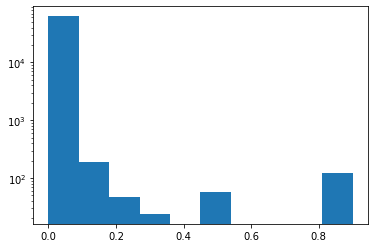

In [103]:
plt.hist(clf.predicted_fracs)
plt.gca().set_yscale('log')